# TinyML - Radial Basis Function Networks

**Author:** Thommas Kevin Sales Flores  

**Institution:** Federal University of Rio Grande do Norte

**Email:** thommas.flores.101@ufrn.edu.br

## 1. Importing Libraries

In [1]:
import sys
sys.path.append("29_RBFN")
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.datasets import make_moons
from sklearn.preprocessing import OneHotEncoder
from model.rbfn import AdvancedRBFNetwork
from model.rbfn_code_generator import RBFArduinoCodeGenerator
from model.rbfn_code_generator import *

## 2. Regression (Sine with Trend)

In [2]:
# 1. Generate synthetic nonlinear data
np.random.seed(42)
X_reg = np.sort(5 * np.random.rand(150, 1), axis=0)
# Function: y = sin(x) + 0.1*x^2 + noise
y_reg = np.sin(X_reg).ravel() + 0.1 * (X_reg.ravel())**2 + 0.15 * np.random.randn(150)

# 2. Split into training and test sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# 3. Configure and Train the RBF Network
# We use 'adaptive' for widths and 'kmeans' for centers
model_reg = AdvancedRBFNetwork(
    hidden_layers=[{'type': 'rbf', 'units': 15}],  # 15 neurons in the hidden layer
    rbf_types='gaussian',
    width_calc_types='adaptive',
    width_value=1.0,        # Width multiplier
    regularization=0.001,   # Prevent overfitting
    normalize_input=True    # Important for RBFs
)

print("Training regression model...")
model_reg.fit(X_train_reg, y_train_reg)

# 4. Evaluate
y_pred_reg = model_reg.predict(X_test_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"Regression Results -> RMSE: {rmse:.4f}, R²: {r2:.4f}")
print(f"Model trained with {len(X_train_reg)} samples, tested on {len(X_test_reg)} samples")

# Optional: Show some predictions
print("\nSample predictions (first 5 test samples):")
for i in range(5):
    print(f"  X={X_test_reg[i][0]:.3f}, True={y_test_reg[i]:.3f}, Predicted={y_pred_reg[i]:.3f}")

Training regression model...
Regression Results -> RMSE: 0.1261, R²: 0.8431
Model trained with 120 samples, tested on 30 samples

Sample predictions (first 5 test samples):
  X=2.160, True=1.287, Predicted=1.272
  X=0.539, True=0.383, Predicted=0.517
  X=3.926, True=0.842, Predicted=0.835
  X=2.476, True=1.263, Predicted=1.198
  X=2.361, True=1.194, Predicted=1.203


### 2.1 Regression Visualization

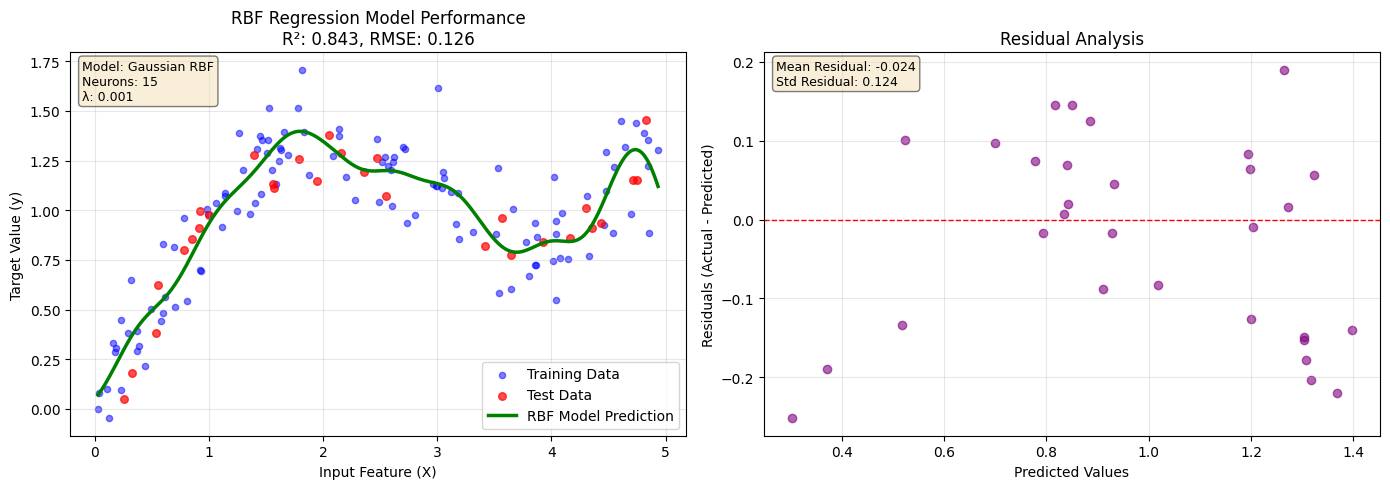

Training samples: 120
Test samples: 30
R² Score: 0.8431
RMSE: 0.1261
Max Error: 0.2522
Mean Absolute Error: 0.1067


In [3]:
# Create a figure with two subplots for regression analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 1. Main Regression Plot
# Generate smooth line for visualization
X_smooth = np.linspace(X_reg.min(), X_reg.max(), 300).reshape(-1, 1)
y_smooth = model_reg.predict(X_smooth)

# Plot training data, test data, and model prediction
ax1.scatter(X_train_reg, y_train_reg, color='blue', alpha=0.5, 
           label='Training Data', s=20)
ax1.scatter(X_test_reg, y_test_reg, color='red', alpha=0.7, 
           label='Test Data', s=30)
ax1.plot(X_smooth, y_smooth, color='green', linewidth=2.5, 
        label='RBF Model Prediction')
ax1.set_title(f'RBF Regression Model Performance\nR²: {r2:.3f}, RMSE: {rmse:.3f}')
ax1.set_xlabel('Input Feature (X)')
ax1.set_ylabel('Target Value (y)')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.text(0.02, 0.98, f'Model: Gaussian RBF\nNeurons: 15\nλ: 0.001', 
        transform=ax1.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Residual Analysis Plot
residuals = y_test_reg - y_pred_reg
ax2.scatter(y_pred_reg, residuals, color='purple', alpha=0.6)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax2.set_title('Residual Analysis')
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Residuals (Actual - Predicted)')
ax2.grid(True, alpha=0.3)

# Add residual statistics
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)
ax2.text(0.02, 0.98, f'Mean Residual: {residual_mean:.3f}\nStd Residual: {residual_std:.3f}', 
        transform=ax2.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Additional Regression Metrics
print(f"Training samples: {len(X_train_reg)}")
print(f"Test samples: {len(X_test_reg)}")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Max Error: {np.max(np.abs(residuals)):.4f}")
print(f"Mean Absolute Error: {np.mean(np.abs(residuals)):.4f}")

### 2.2 Save Regression Model

In [4]:
print("Saving regression model...")
model_reg.save_json('output/rbf_regression_model.json')
print("Regression model saved as 'output/rbf_regression_model.json'")

Saving regression model...
Model saved at: output/rbf_regression_model.json
Regression model saved as 'output/rbf_regression_model.json'


### 2.3 Code Generation

In [5]:
gen = RBFArduinoCodeGenerator("output/rbf_regression_model.json")
gen.generate("output/esp32_regression", target_device="esp32")

✅ Generated RbfRegressionModelRBF for esp32 in output\esp32_regression


{'RbfRegressionModelRBF.h': '#ifndef RBFREGRESSIONMODELRBF_H\n#define RBFREGRESSIONMODELRBF_H\n\n#include <Arduino.h>\n#include <math.h>\n\n// Dimensions\n#define RBF_INPUT_DIM 1\n#define RBF_HIDDEN_DIM 15\n#define RBF_OUTPUT_DIM 1\n#define RBF_SCALE_FACTOR 1\n#define RBF_FIXED_POINT 0\n#define RBF_USE_NORMALIZATION 1\n\ntypedef float rbf_float;\n\nclass RbfRegressionModelRBF {\npublic:\n    RbfRegressionModelRBF();\n    void predict(const rbf_float* input, rbf_float* output);\n    void printInfo();\n\nprivate:\n    rbf_float computeKernel(rbf_float dist_sq, rbf_float width);\n    rbf_float euclideanDistanceSq(const rbf_float* input, int center_idx);\n\n    // Buffers\n    rbf_float hidden_activations[RBF_HIDDEN_DIM];\n    \n    // Internal Normalization Helpers\n    void normalizeInput(const rbf_float* input, rbf_float* norm_input);\n    void denormalizeOutput(rbf_float* output);\n};\n\n#endif\n',
 'RbfRegressionModelRBF.cpp': '#include "RbfRegressionModelRBF.h"\n\n// ================

## 3. Classification (Make Moons)

In [10]:
# 1. Generate data (two intertwined moons - nonlinear)
X_cls, y_cls = make_moons(n_samples=300, noise=0.15, random_state=42)

# 2. Preprocessing: One-Hot Encoding
# Since the standard method is direct solution (least squares), we transform
# classes into vectors (e.g., class 0 -> [1, 0], class 1 -> [0, 1])
enc = OneHotEncoder(sparse_output=False)
y_cls_encoded = enc.fit_transform(y_cls.reshape(-1, 1))

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls_encoded, test_size=0.3, random_state=42)

# 3. Configure and Train
model_cls = AdvancedRBFNetwork(
    hidden_layers=[{'type': 'rbf', 'units': 30}], # More units for complex boundaries
    width_value=0.5,       # Smaller width allows sharper curves
    regularization=0.001,
    normalize_input=True
)

print("Training classification model...")
model_cls.fit(X_train_cls, y_train_cls)

# 4. Evaluate
# The model returns continuous probabilities/scores, we use argmax to get the class
y_pred_scores = model_cls.predict(X_test_cls)
y_pred_classes = np.argmax(y_pred_scores, axis=1)
y_true_classes = np.argmax(y_test_cls, axis=1)

acc = accuracy_score(y_true_classes, y_pred_classes)
print(f"Classification Results -> Accuracy: {acc:.4f}")
print(f"Model trained with {len(X_train_cls)} samples, tested on {len(X_test_cls)} samples")
print("\nDetailed Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Class 0', 'Class 1']))

# Confusion Matrix (optional)
print("\nConfusion Matrix (predicted vs actual):")
unique_classes = np.unique(y_true_classes)
for i in unique_classes:
    for j in unique_classes:
        count = np.sum((y_true_classes == i) & (y_pred_classes == j))
        print(f" Input = {X_test_cls[i]} | True = {i} | Predicted = {j}")

Training classification model...
Classification Results -> Accuracy: 0.9556
Model trained with 210 samples, tested on 90 samples

Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       0.90      1.00      0.95        38
     Class 1       1.00      0.92      0.96        52

    accuracy                           0.96        90
   macro avg       0.95      0.96      0.95        90
weighted avg       0.96      0.96      0.96        90


Confusion Matrix (predicted vs actual):
 Input = [ 0.50799168 -0.34745972] | True = 0 | Predicted = 0
 Input = [ 0.50799168 -0.34745972] | True = 0 | Predicted = 1
 Input = [2.31773412 0.49561119] | True = 1 | Predicted = 0
 Input = [2.31773412 0.49561119] | True = 1 | Predicted = 1


### 3.1 Classification Visualization

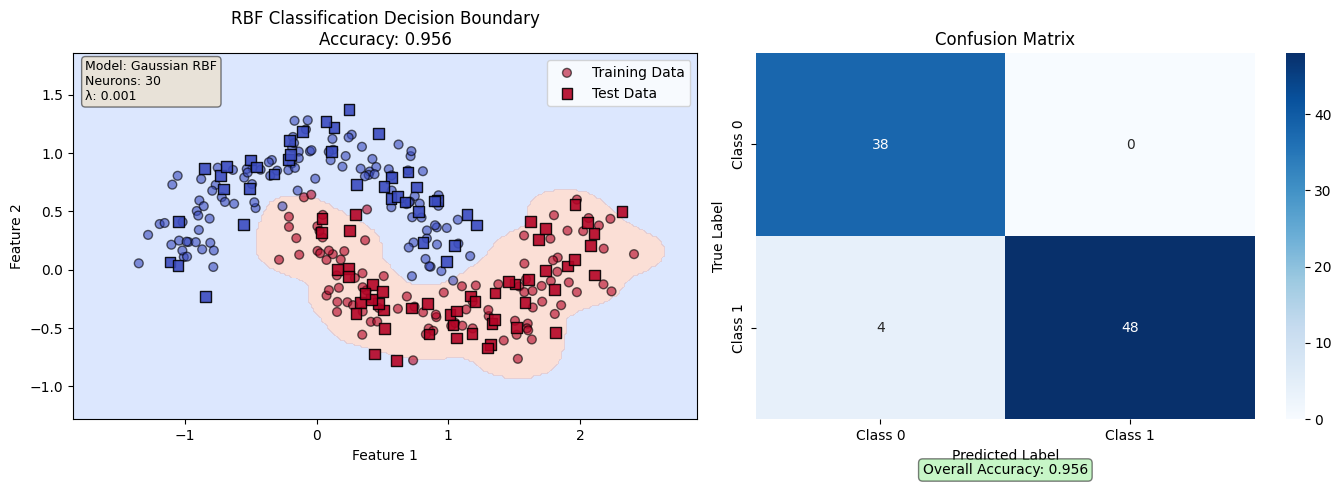


Classification Model Details:
------------------------------
Training samples: 210
Test samples: 90
Accuracy: 0.9556

Per-class Metrics:
  Class 0: Precision=0.905, Recall=1.000, F1-score=0.950
  Class 1: Precision=1.000, Recall=0.923, F1-score=0.960


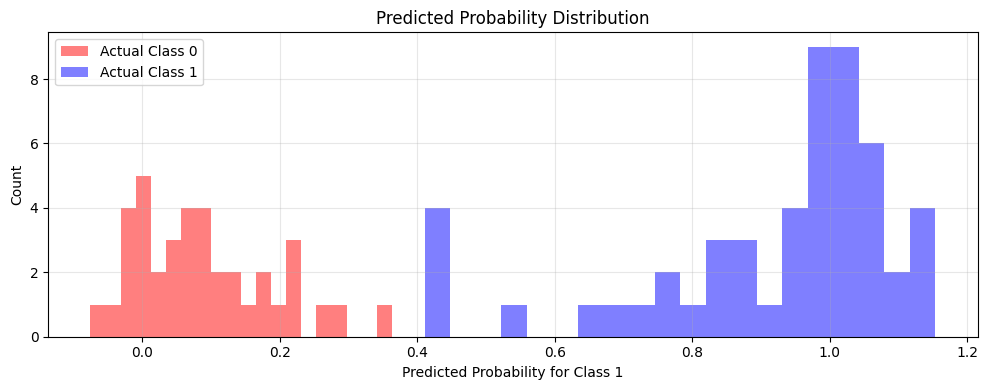

In [7]:
# Create a figure with two subplots for classification analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 1. Decision Boundary Plot
# Create mesh grid for decision boundary visualization
x_min, x_max = X_cls[:, 0].min() - 0.5, X_cls[:, 0].max() + 0.5
y_min, y_max = X_cls[:, 1].min() - 0.5, X_cls[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), 
                    np.arange(y_min, y_max, 0.02))

# Predict the entire grid
Z = model_cls.predict(np.c_[xx.ravel(), yy.ravel()])
Z_classes = np.argmax(Z, axis=1).reshape(xx.shape)

# Plot decision boundary
contour = ax1.contourf(xx, yy, Z_classes, alpha=0.3, cmap='coolwarm', levels=1)

# Plot training data
ax1.scatter(X_train_cls[:, 0], X_train_cls[:, 1], 
           c=np.argmax(y_train_cls, axis=1), 
           edgecolors='k', cmap='coolwarm', s=40, alpha=0.6,
           label='Training Data', marker='o')

# Plot test data with different marker
ax1.scatter(X_test_cls[:, 0], X_test_cls[:, 1], 
           c=y_true_classes, 
           edgecolors='k', cmap='coolwarm', s=60, alpha=0.9,
           label='Test Data', marker='s')

ax1.set_title(f'RBF Classification Decision Boundary\nAccuracy: {acc:.3f}')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.legend(loc='best')

# Add model info to plot
ax1.text(0.02, 0.98, f'Model: Gaussian RBF\nNeurons: 30\nλ: 0.001', 
        transform=ax1.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Confusion Matrix Visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
           xticklabels=['Class 0', 'Class 1'],
           yticklabels=['Class 0', 'Class 1'])

ax2.set_title('Confusion Matrix')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

# Add accuracy to confusion matrix plot
ax2.text(0.5, -0.15, f'Overall Accuracy: {acc:.3f}', 
        transform=ax2.transAxes, ha='center',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

# 3. Additional Classification Metrics Visualization
print("\nClassification Model Details:")
print("-" * 30)
print(f"Training samples: {len(X_train_cls)}")
print(f"Test samples: {len(X_test_cls)}")
print(f"Accuracy: {acc:.4f}")

# Calculate per-class metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)

print("\nPer-class Metrics:")
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f"  Class {i}: Precision={p:.3f}, Recall={r:.3f}, F1-score={f:.3f}")

# 4. Probability Distribution Visualization (optional)
fig, ax = plt.subplots(figsize=(10, 4))

# Get predicted probabilities for class 1
class1_probs = y_pred_scores[:, 1]

# Create histogram of predicted probabilities
n_bins = 20
ax.hist(class1_probs[y_true_classes == 0], bins=n_bins, 
        alpha=0.5, label='Actual Class 0', color='red')
ax.hist(class1_probs[y_true_classes == 1], bins=n_bins, 
        alpha=0.5, label='Actual Class 1', color='blue')

ax.set_title('Predicted Probability Distribution')
ax.set_xlabel('Predicted Probability for Class 1')
ax.set_ylabel('Count')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.2 Save Regression Model

In [8]:
print("Saving Classification model...")
model_cls.save_json('output/rbf_classification_model.json')
print("Classification model saved as 'output/rbf_classification_model.json'")

Saving Classification model...
Model saved at: output/rbf_classification_model.json
Classification model saved as 'output/rbf_classification_model.json'


### 3.3 Code Generation

In [9]:

gen_classification = RBFArduinoCodeGenerator("output/rbf_classification_model.json")
gen_classification.generate("output/esp32_classification", target_device="esp32")

✅ Generated RbfClassificationModelRBF for esp32 in output\esp32_classification


{'RbfClassificationModelRBF.h': '#ifndef RBFCLASSIFICATIONMODELRBF_H\n#define RBFCLASSIFICATIONMODELRBF_H\n\n#include <Arduino.h>\n#include <math.h>\n\n// Dimensions\n#define RBF_INPUT_DIM 2\n#define RBF_HIDDEN_DIM 30\n#define RBF_OUTPUT_DIM 2\n#define RBF_SCALE_FACTOR 1\n#define RBF_FIXED_POINT 0\n#define RBF_USE_NORMALIZATION 1\n\ntypedef float rbf_float;\n\nclass RbfClassificationModelRBF {\npublic:\n    RbfClassificationModelRBF();\n    void predict(const rbf_float* input, rbf_float* output);\n    void printInfo();\n\nprivate:\n    rbf_float computeKernel(rbf_float dist_sq, rbf_float width);\n    rbf_float euclideanDistanceSq(const rbf_float* input, int center_idx);\n\n    // Buffers\n    rbf_float hidden_activations[RBF_HIDDEN_DIM];\n    \n    // Internal Normalization Helpers\n    void normalizeInput(const rbf_float* input, rbf_float* norm_input);\n    void denormalizeOutput(rbf_float* output);\n};\n\n#endif\n',
 'RbfClassificationModelRBF.cpp': '#include "RbfClassificationModelR